In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Import Dataset
file_path = "/Users/edoardonicoletti/Desktop/EDHEC M2/Research_methodologies/pe_ratio.xlsx"

#Load the excel
xls = pd.ExcelFile(file_path)

#Take the first sheet
df_pe = pd.read_excel(xls, sheet_name="PE_ratio_hist")  # adjust the sheet name if necessary

#Set Index
df_pe.set_index('Dates', inplace=True)

#Check
df_pe.head(5)

,LYB UN Equity,AXP UN Equity,VZ UN Equity,TPL UN Equity,AVGO UW Equity,BA UN Equity,SOLV UN Equity,CAT UN Equity,JPM UN Equity,CVX UN Equity,...,TRGP UN Equity,BG UN Equity,LKQ UW Equity,DECK UN Equity,WDAY UW Equity,ZTS UN Equity,EQIX UW Equity,DLR UN Equity,MOH UN Equity,LVS UN Equity
Dates,,,,,,,,,,,,,,,,,,,,,
2000-01-03,NaN,25.778003,18.108255,NaN,NaN,18.691622,NaN,15.105666,NaN,19.212342,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,NaN,24.794806,17.312240,NaN,NaN,18.684300,NaN,14.896168,NaN,19.081546,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05,NaN,24.119515,18.116766,NaN,NaN,19.809803,NaN,15.326513,NaN,19.557969,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-06,NaN,24.615003,17.830238,NaN,NaN,20.005297,NaN,15.988250,NaN,20.332253,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-07,NaN,24.932500,17.768059,NaN,NaN,20.577948,NaN,16.479176,NaN,20.674802,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
#Extracting Apple P/E
pe_aapl = df_pe[['AAPL UW Equity']].dropna()
pe_aapl = pe_aapl.rename(columns={'AAPL UW Equity': 'PE_Ratio'})

In [4]:
#Weekly data to ensure comparability as in the dummy strategy
pe_aapl_weekly = pe_aapl.resample('W-FRI').last()

In [5]:
#Compare range as in the dummy strategy
pe_aapl_weekly= pe_aapl_weekly.loc['2014-12-12':'2016-12-12']

In [6]:
#Calculating Mean Over the reference Range
pe_value_mean = pe_aapl_weekly.mean()

In [7]:
default_std = pe_aapl_weekly.std()

In [8]:
def generate_signals(pe_series, window, k, pe_value=pe_value_mean, default_std=default_std):
    # 1. Rolling stats
    rolling_mean = pe_series.rolling(window=window).mean()
    rolling_std = pe_series.rolling(window=window).std()

    # 2. Fill missing values with default assumptions
    rolling_mean_filled = rolling_mean.fillna(pe_value)
    rolling_std_filled = rolling_std.fillna(default_std)

    # 3. Create upper/lower bands
    upper_band = rolling_mean_filled + k * rolling_std_filled
    lower_band = rolling_mean_filled - k * rolling_std_filled

    # 4. Generate trading signals
    signals = pd.Series(0, index=pe_series.index)
    signals[pe_series < lower_band] = 1   # Long
    signals[pe_series > upper_band] = -1  # Short

    # 5. Return filled values (used for plotting) and signals
    return signals, rolling_mean_filled, upper_band, lower_band

In [9]:
signals, rolling_mean, upper_band, lower_band = generate_signals(
    pe_aapl_weekly["PE_Ratio"], window=5, k=0.5
)

In [10]:
def get_weekly_prices(ticker, start, end):
    data = yf.download(ticker, start=start, end=end)  # auto_adjust=True is default
    data.index = pd.to_datetime(data.index)
    weekly_prices = data['Close'].resample('W-FRI').last()
    return weekly_prices.dropna()

In [11]:
TICKER = "AAPL"
START_DATE = "2014-12-12"
END_DATE = "2016-12-12"

In [12]:
weekly_prices=get_weekly_prices(TICKER, START_DATE,END_DATE)
weekly_prices.head(5)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Ticker,AAPL
Date,
2014-12-12,24.409410
2014-12-19,24.865431
2014-12-26,25.357048
2015-01-02,24.320433
2015-01-09,24.916595


In [13]:
returns = weekly_prices.pct_change().fillna(0)

In [14]:
#Ensuring it will be 1 DImensional
if isinstance(returns, pd.DataFrame):
    returns = returns['AAPL']

In [15]:
strategy_returns = signals.shift(1) * returns 

In [16]:
cumulative_returns = (1 + strategy_returns).cumprod()
cumulative_returns

Dates
2014-12-12         NaN
2014-12-19    1.000000
2014-12-26    1.000000
2015-01-02    1.000000
2015-01-09    1.000000
                ...   
2016-11-11    1.117887
2016-11-18    1.134692
2016-11-25    1.152528
2016-12-02    1.152528
2016-12-09    1.195001
Freq: W-FRI, Length: 105, dtype: float64

In [17]:
results_df = pd.DataFrame({
    "Signal": signals,
    "P/E": pe_aapl_weekly["PE_Ratio"],
    "Upper Band": upper_band,
    "Lower band": lower_band,
    "Return": returns,
    "Strategy_Return": strategy_returns,
    "Cumulative_Return": cumulative_returns
})

In [18]:
def plot_results(cumulative_returns, pe_series, rolling_mean, upper_band, lower_band, signals):
    # Align series
    signals = signals.loc[pe_series.index]

    fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    # Plot cumulative returns
    axs[0].plot(cumulative_returns, label='Strategy Cumulative Return')
    axs[0].set_title("Value Strategy on AAPL (P/E-based)")
    axs[0].set_ylabel("Cumulative Return")
    axs[0].legend()
    axs[0].grid(True)

    # Plot P/E and signals
    axs[1].plot(pe_series, label='P/E', color='black', alpha=0.6)
    axs[1].plot(rolling_mean, label='Rolling Mean', linestyle='--')
    axs[1].plot(upper_band, label='Upper Band', linestyle=':')
    axs[1].plot(lower_band, label='Lower Band', linestyle=':')

    axs[1].scatter(signals[signals == 1].index, pe_series[signals == 1], label='Long', marker='^', color='green')
    axs[1].scatter(signals[signals == -1].index, pe_series[signals == -1], label='Short', marker='v', color='red')

    axs[1].set_title("Simulated P/E with Signal Bands")
    axs[1].set_ylabel("P/E Ratio")
    axs[1].legend()
    axs[1].grid(True)

    plt.xlabel("Date")
    plt.tight_layout()
    plt.show()

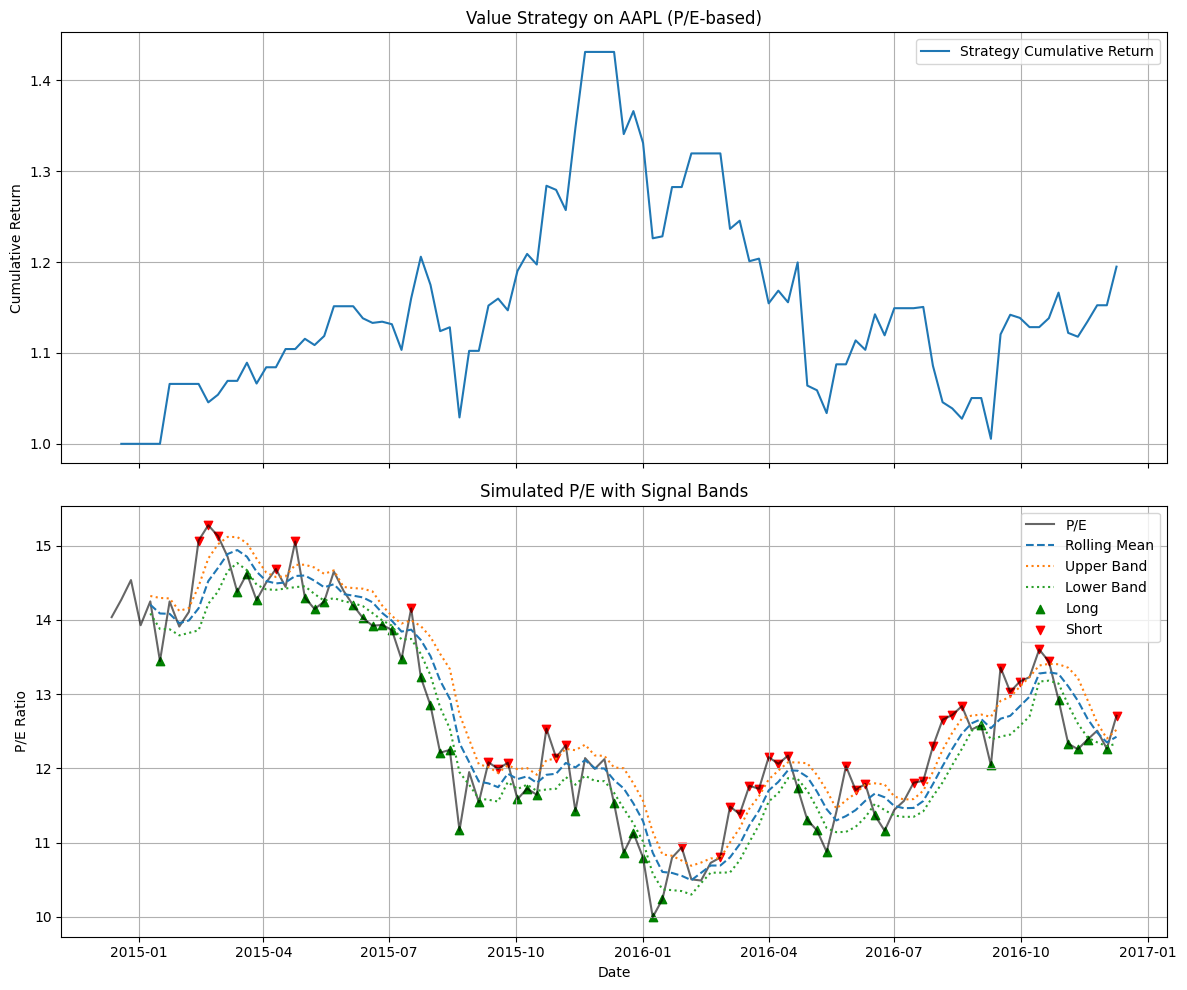

In [19]:
plot_results(cumulative_returns, pe_aapl_weekly, rolling_mean, upper_band, lower_band, signals)

In [24]:
# Define base transaction cost
base_cost = 0.001  # 0.1% per trade

# Compute rolling volatility need to choose the time frame
rolling_vol = returns.rolling(window=4).std()

# Normalize volatility relative to mean so to avoid extreme values 
scaled_vol = rolling_vol / rolling_vol.mean()

# Compute dynamic cost
dynamic_cost_per_trade = base_cost * scaled_vol

# Detect position changes (you trade only when signal changes)
position = signals.shift(1)  # Position held at each time step
position_change = position.diff().abs().fillna(0)  # 0→1 or 1→-1 etc.

# Compute transaction costs
transaction_costs = dynamic_cost_per_trade * position_change

# Apply cost to strategy returns
strategy_returns_net = strategy_returns - transaction_costs

# Recalculate cumulative returns
cumulative_returns_net = (1 + strategy_returns_net).cumprod()

# Store everything in the results DataFrame
results_df["Rolling_Vol"] = rolling_vol
results_df["Dynamic_Cost"] = transaction_costs
results_df["Strategy_Return_Net"] = strategy_returns_net
results_df["Cumulative_Return_Net"] = cumulative_returns_net


### The cost structure applies transaction costs only when a position change occurs, such as moving from long to short or from a position to cash. These costs are adjusted dynamically according to market volatility. In periods of high volatility, transaction costs are higher due to wider bid-ask spreads and increased slippage, while in stable periods, costs are lower. This approach creates a more realistic backtest by reflecting the true cost of trading under different market conditions.

In [25]:
results_df.tail(5)

,Signal,P/E,Upper Band,Lower band,Return,Strategy_Return,Cumulative_Return,Rolling_Vol,Dynamic_Cost,Strategy_Return_Net,Cumulative_Return_Net
2016-11-11,1,12.256765,13.218503,12.602629,-0.003767,-0.003767,1.117887,0.015602,0.000000,-0.003767,1.060691
2016-11-18,1,12.386840,12.920281,12.415248,0.015033,0.015033,1.134692,0.023330,0.000000,0.015033,1.076636
2016-11-25,0,12.507071,12.613091,12.349668,0.015719,0.015719,1.152528,0.025172,0.000000,0.015719,1.093560
2016-12-02,1,12.264218,12.400996,12.298069,-0.016907,-0.000000,1.152528,0.015787,0.000464,-0.000464,1.093053
2016-12-09,-1,12.707843,12.518869,12.330226,0.036852,0.036852,1.195001,0.022169,0.000651,0.036201,1.132622


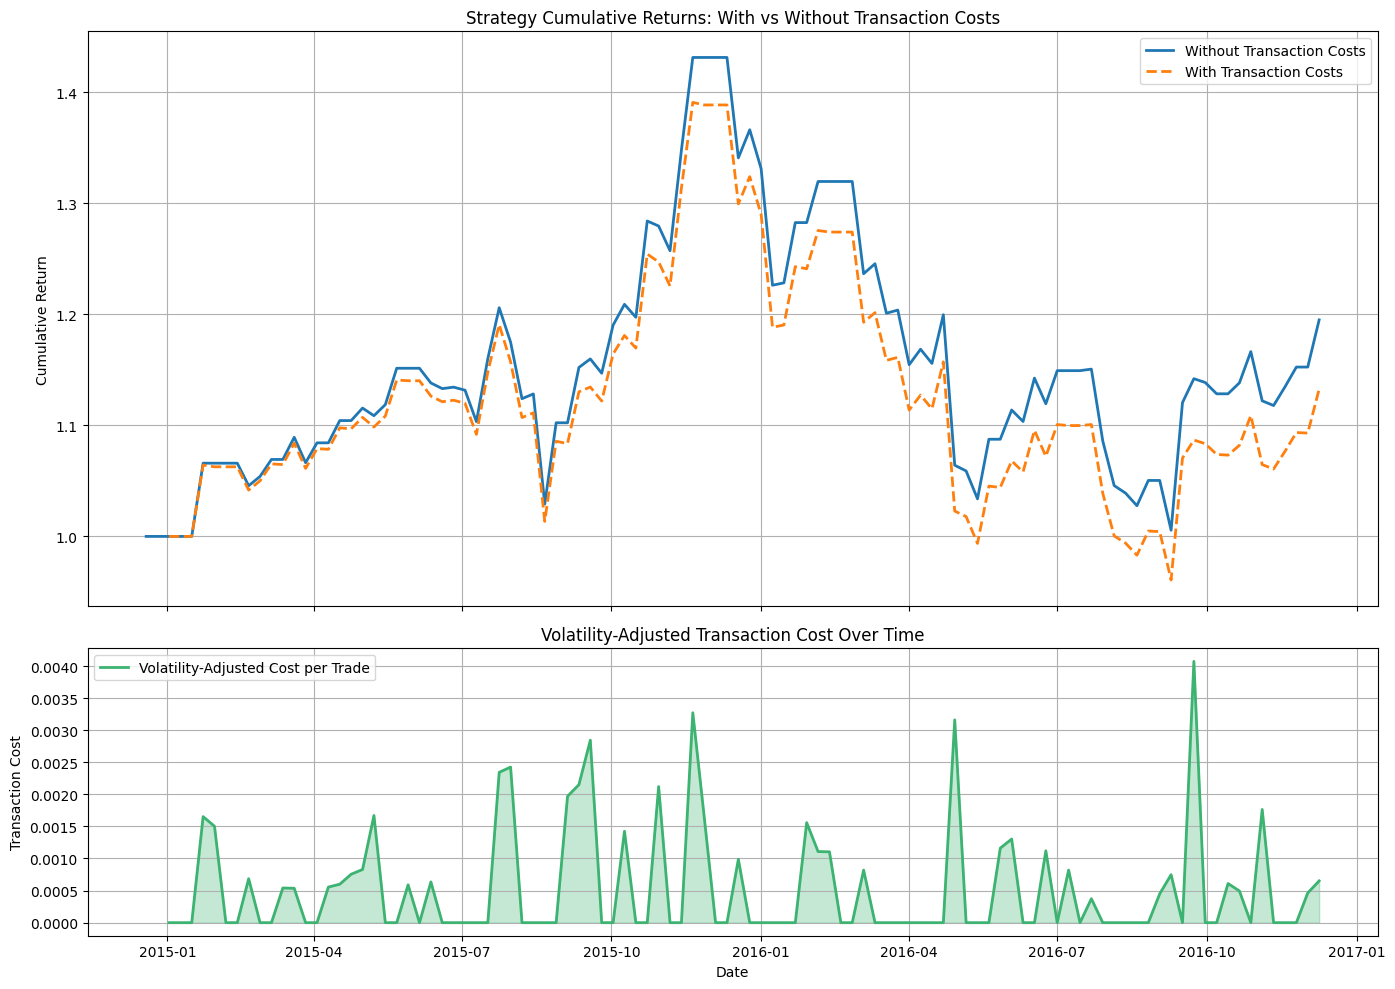

In [28]:
# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# Top plot
axs[0].plot(results_df["Cumulative_Return"], label="Without Transaction Costs", linewidth=2)
axs[0].plot(results_df["Cumulative_Return_Net"], label="With Transaction Costs", linewidth=2, linestyle='--')
axs[0].set_title("Strategy Cumulative Returns: With vs Without Transaction Costs")
axs[0].set_ylabel("Cumulative Return")
axs[0].legend()
axs[0].grid(True)

# Bottom plot
axs[1].plot(results_df["Dynamic_Cost"], label="Volatility-Adjusted Cost per Trade", color='mediumseagreen', linewidth=2)
axs[1].fill_between(results_df.index, results_df["Dynamic_Cost"], alpha=0.3, color='mediumseagreen')
axs[1].set_title("Volatility-Adjusted Transaction Cost Over Time")
axs[1].set_ylabel("Transaction Cost")
axs[1].set_xlabel("Date")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()